In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def print_fancy(arr):
    for i in range(0, len(arr), 5):
        print(arr[i:i + 5])


def normalize(arr):
    m = sum(arr) / len(arr)
    return [a - m for a in arr]


btc_trades = pd.read_csv("../../Downloads/md/md/btcusdt_Binance_LinearPerpetual/trades.csv", nrows=10000)
btc_lobs = pd.read_csv("../../Downloads/md/md/btcusdt_Binance_LinearPerpetual/lobs.csv", nrows=10000)

eth_trades = pd.read_csv("../../Downloads/md/md/ethusdt_Binance_LinearPerpetual/trades.csv", nrows=10000)
eth_lobs = pd.read_csv("../../Downloads/md/md/ethusdt_Binance_LinearPerpetual/lobs.csv", nrows=10000)

data = [(btc_trades, btc_lobs, 'btcusdt'), (eth_trades, eth_lobs, 'ethusdt')]

In [28]:
print(btc_trades.shape)
print(btc_lobs.shape)
print(eth_trades.shape)
print(eth_lobs.shape)

(10000, 5)
(10000, 42)
(10000, 5)
(10000, 42)


(1)-btcusdt Plot prices of trades made. Best ask. Best bid.


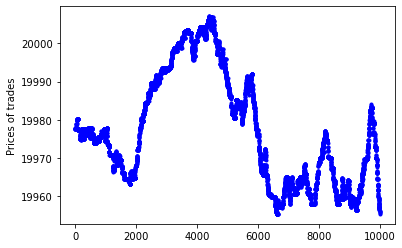

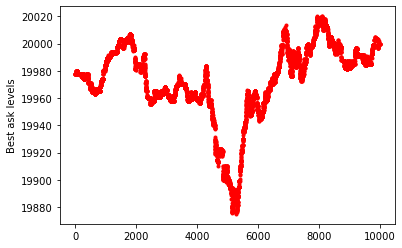

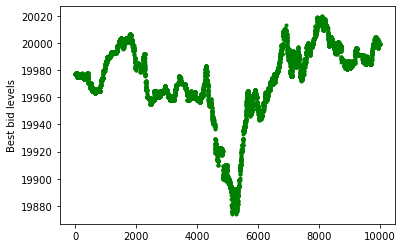

(1)-ethusdt Plot prices of trades made. Best ask. Best bid.


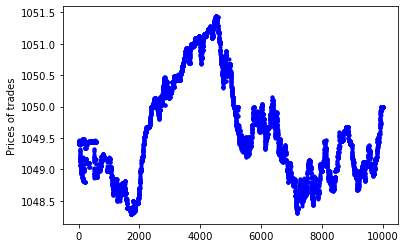

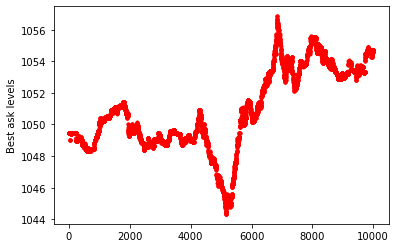

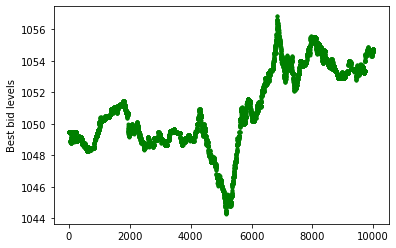

In [29]:
def plots(df_trades, df_lobs, label):
    print('(1)-%s Plot prices of trades made. Best ask. Best bid.' % label)

    plt.plot(df_trades['price'], 'b.')
    plt.ylabel('Prices of trades')
    plt.show()

    plt.plot(df_lobs[label + ':Binance:LinearPerpetual_ask_price_0'], 'r.')
    plt.ylabel('Best ask levels')
    plt.show()
    
    plt.plot(df_lobs[label + ':Binance:LinearPerpetual_bid_price_0'], 'g.')
    plt.ylabel('Best bid levels')
    plt.show()


for trades, lobs, label in data:
    plots(trades, lobs, label)

In [30]:
def stats(df_trades, df_lobs, label):
    print('\n(2)-%s Printing statistics of Trade size' % label)

    arr = sorted(list(df_trades['size']))
    n = len(arr)
    q05 = int(n * 0.05)
    p05 = arr[q05]
    p95 = arr[n - q05]
    med = arr[n // 2]
    mean = sum(arr) / n
    D = sum((a - mean) ** 2 for a in arr) / n

    print('0.05 quantile', p05)
    print('0.95 quantile', p95)
    print('Median', med)
    print('Mean', mean)
    print('Variance', D)


for trades, lobs, label in data:
    stats(trades, lobs, label)


(2)-btcusdt Printing statistics of Trade size
0.05 quantile 0.001
0.95 quantile 0.499
Median 0.012
Mean 0.12087979999999952
Variance 0.15026700475196017

(2)-ethusdt Printing statistics of Trade size
0.05 quantile 0.005
0.95 quantile 5.0
Median 0.12
Mean 1.4516959000000011
Variance 147.79488475782318


(3)-btcusdt Plot histograms


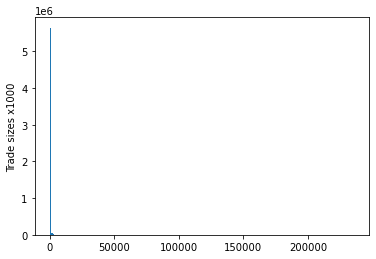

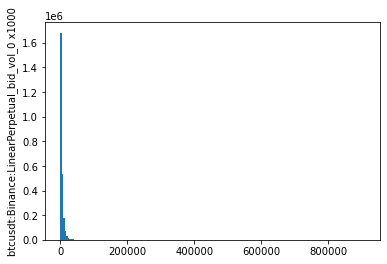

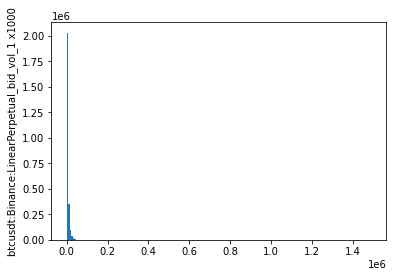

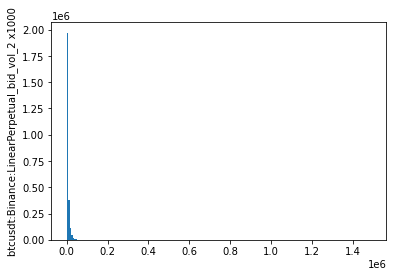

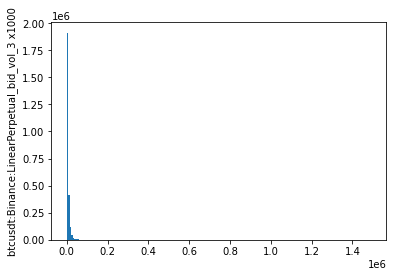

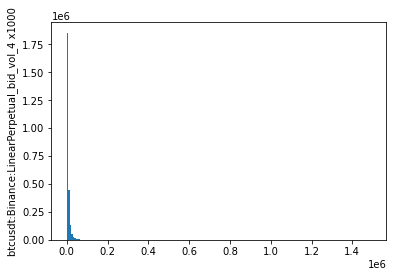

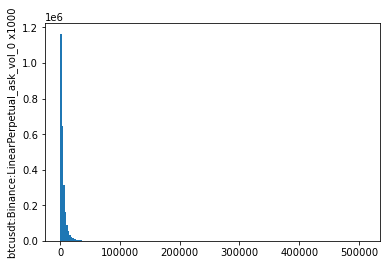

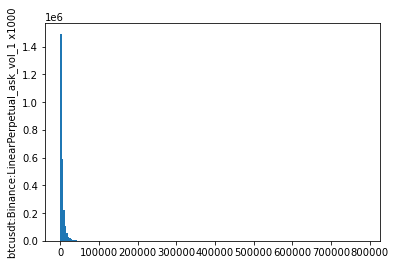

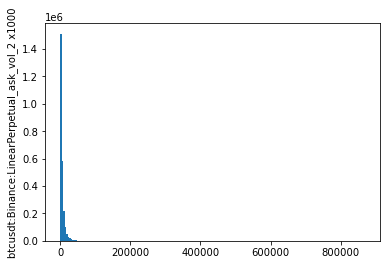

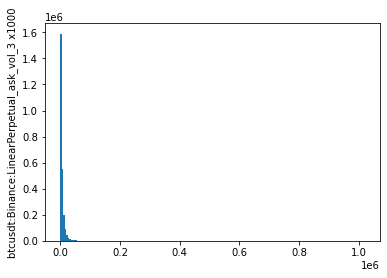

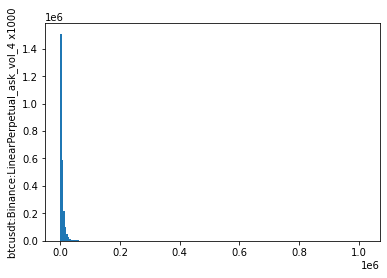

(3)-ethusdt Plot histograms


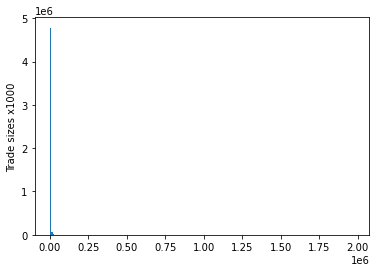

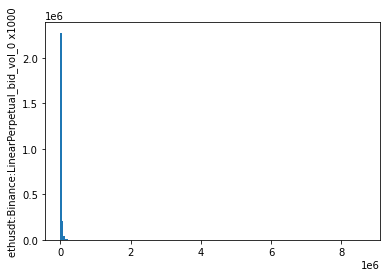

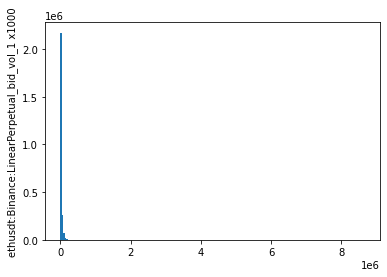

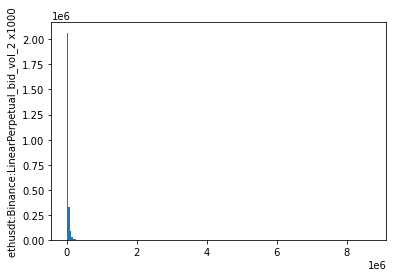

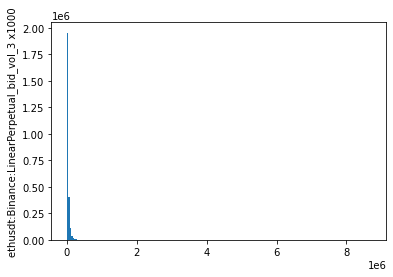

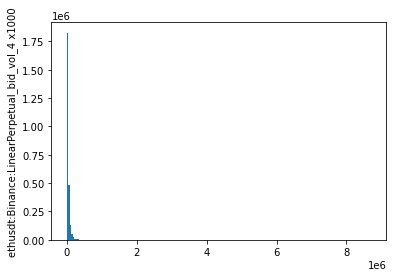

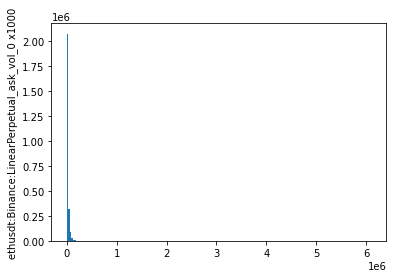

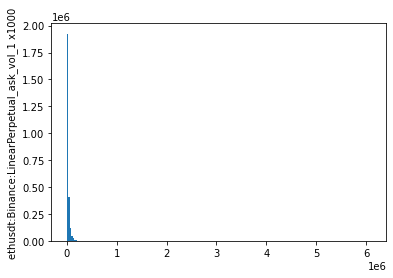

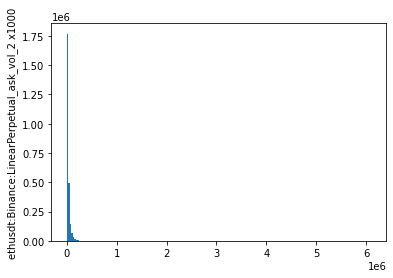

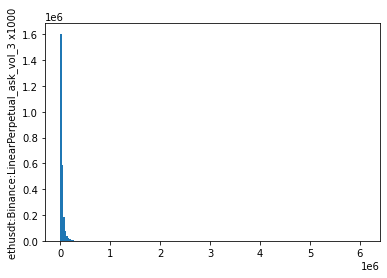

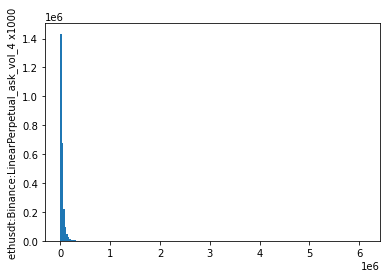

In [24]:
def histograms(df_trades, df_lobs, label):
    print('(3)-%s Plot histograms' % label)

    def hist(arr, label):
        arr = [int(1000 * a) for a in arr]
        plt.hist(arr, bins=200)
        plt.ylabel(label)
        plt.show()

    hist(df_trades['size'], 'Trade sizes x1000')

    cols = [label + ':Binance:LinearPerpetual_bid_vol_0', label + ':Binance:LinearPerpetual_bid_vol_1', 
            label + ':Binance:LinearPerpetual_bid_vol_2',
            label + ':Binance:LinearPerpetual_bid_vol_3', label + ':Binance:LinearPerpetual_bid_vol_4']

    arr = df_lobs[cols[0]]
    for i in range(len(cols)):
        if i != 0:
            arr += df_lobs[cols[i]]
        hist(arr, cols[i] + ' x1000')

    cols = [label + ':Binance:LinearPerpetual_ask_vol_0', label + ':Binance:LinearPerpetual_ask_vol_1', 
            label + ':Binance:LinearPerpetual_ask_vol_2',
            label + ':Binance:LinearPerpetual_ask_vol_3', label + ':Binance:LinearPerpetual_ask_vol_4']

    arr = df_lobs[cols[0]]
    for i in range(len(cols)):
        if i != 0:
            arr += df_lobs[cols[i]]
        hist(arr, cols[i] + ' x1000')


for trades, lobs, label in data:
    histograms(trades, lobs, label)

(4)-btcusdt Probitiye stakana


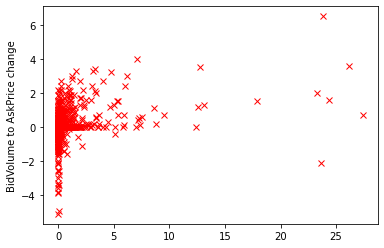

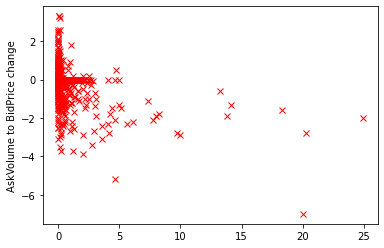

(4)-ethusdt Probitiye stakana


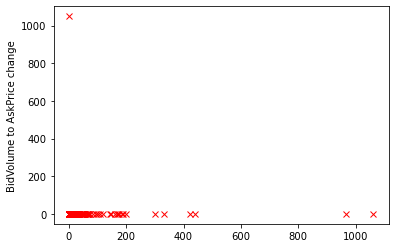

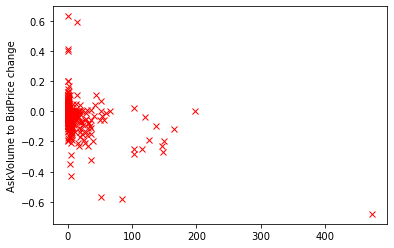

In [31]:
def probitiye_stakana(df_trades, df_lobs, label):
    print('(4)-%s Probitiye stakana' % label)

    evs = []
    for i in range(df_trades.shape[0]):
        evs.append((df_trades.iloc[i]['exchange_ts'], 'trade', df_trades.iloc[i]['aggro_side'], df_trades.iloc[i]['size']))

    for i in range(df_lobs.shape[0]):
        evs.append((df_lobs.iloc[i][' exchange_ts'], 'exch_prices',
                    df_lobs.iloc[i][label + ':Binance:LinearPerpetual_ask_price_0'],
                    df_lobs.iloc[i][label + ':Binance:LinearPerpetual_bid_price_0']))

    evs.sort(key=lambda t: t[0])
    # print_fancy(evs[:50])

    last_ask, last_bid = 0, 0
    acc_vol_bid, acc_vol_ask = 0, 0

    bid_vol2pr_ch = []
    ask_vol2pr_ch = []

    for _, t, a, b in evs:
        if t == 'trade':
            if a == 'BID':
                acc_vol_bid += b
            elif a == 'ASK':
                acc_vol_ask += b
            else:
                print('Error parsing events')
        else:
            # record change
            if acc_vol_bid != 0:
                bid_vol2pr_ch.append((acc_vol_bid, a - last_ask))
            if acc_vol_ask != 0:
                ask_vol2pr_ch.append((acc_vol_ask, b - last_bid))

            last_ask = a
            last_bid = b
            acc_vol_bid, acc_vol_ask = 0, 0

    xs = [x for x, _ in bid_vol2pr_ch]
    ys = [y for _, y in bid_vol2pr_ch]
    plt.plot(xs, ys, 'rx')
    plt.ylabel('BidVolume to AskPrice change')
    plt.show()

    xs = [x for x, _ in ask_vol2pr_ch]
    ys = [y for _, y in ask_vol2pr_ch]
    plt.plot(xs, ys, 'rx')
    plt.ylabel('AskVolume to BidPrice change')
    plt.show()


for trades, lobs, label in data:
    probitiye_stakana(trades, lobs, label)

(5) Relation btw ETH and BTC


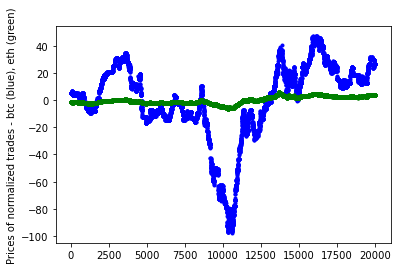

In [32]:
def relation():
    print('(5) Relation btw ETH and BTC')

    evs = []
    for i in range(eth_lobs.shape[0]):
        time = eth_lobs.iloc[i][' exchange_ts']
        price = (eth_lobs.iloc[i]['ethusdt:Binance:LinearPerpetual_ask_price_0'] + eth_lobs.iloc[i][
            'ethusdt:Binance:LinearPerpetual_bid_price_0']) / 2
        evs.append((time, 'eth', price))

    for i in range(btc_lobs.shape[0]):
        time = btc_lobs.iloc[i][' exchange_ts']
        price = (btc_lobs.iloc[i]['btcusdt:Binance:LinearPerpetual_ask_price_0'] + btc_lobs.iloc[i][
            'btcusdt:Binance:LinearPerpetual_bid_price_0']) / 2
        evs.append((time, 'btc', price))

    evs.sort()
    x_eth, y_eth, x_btc, y_btc = [], [], [], []

    for i, (ts, c, pr) in enumerate(evs):
        if c == 'eth':
            x_eth.append(i)
            y_eth.append(pr)
        else:
            x_btc.append(i)
            y_btc.append(pr)

    plt.plot(x_btc, normalize(y_btc), 'b.')
    plt.plot(x_eth, normalize(y_eth), 'g.')
    plt.ylabel('Prices of normalized trades - btc (blue), eth (green)')
    plt.show()


relation()